In [30]:
import matplotlib.pyplot as plt
import numpy as np
from goes2go import GOES
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import xarray as xr
import os
import metpy
from pyproj import Proj

from goes2go.data import goes_timerange

import sys
sys.path.append('/home/cdalden/goes_work/processing/')

from utils import calculate_degrees 

In [10]:
start = "2023-02-06 16:00"
end = "2023-02-06 22:00"

# g = goes_timerange(start, end, satellite="16", product="ABI-L2-ACMC", domain='C')

In [11]:
year = '2023'
month = '02'
day = '06'
time = '16:02:00'

rgb_path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
rgb_file = 'goes16_C02_C05_C13_rgb_colorado_{year}{month}{day}.nc'.format(year=year, month=month, day=day)
rgb_ds = xr.open_dataset(rgb_path + rgb_file)
rgb_ds = rgb_ds.sel(t=(f'{year}-{month}-{day}T{time}'), method='nearest')

# G = GOES(satellite=16, product="ABI-L2-ACMC", domain='C')
# ds = G.nearesttime('{year}-{month}-{day} {time}'.format(year=year, month=month, day=day, time=time))
# ds

In [12]:
rgb_ds

<xarray.Dataset> Size: 12MB
Dimensions:    (latitude: 640, longitude: 966)
Coordinates:
  * latitude   (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.01 37.0
  * longitude  (longitude) float64 8kB -109.0 -109.0 -109.0 ... -104.0 -104.0
    t          datetime64[ns] 8B 2023-02-06T16:02:30
Data variables:
    green      (latitude, longitude) float32 2MB ...
    blue       (latitude, longitude) float64 5MB ...
    red        (latitude, longitude) float64 5MB ...

In [13]:
may_mask = ((rgb_ds.red <= 0.23) & (rgb_ds.blue >= 0.26) | ((rgb_ds.red > 0.23) & (rgb_ds.blue >= 0.16)))
winter_mask = (rgb_ds.red>0.39) & (rgb_ds.blue>0.13)
clouds = xr.where(winter_mask, 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
rgb_ds['clouds'] = clouds

rgb_ds

<xarray.Dataset> Size: 17MB
Dimensions:    (latitude: 640, longitude: 966)
Coordinates:
  * latitude   (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.01 37.0
  * longitude  (longitude) float64 8kB -109.0 -109.0 -109.0 ... -104.0 -104.0
    t          datetime64[ns] 8B 2023-02-06T16:02:30
Data variables:
    green      (latitude, longitude) float32 2MB ...
    blue       (latitude, longitude) float64 5MB 0.1389 0.1389 ... 0.1077 0.1077
    red        (latitude, longitude) float64 5MB 0.3684 0.3684 ... 0.0891 0.0891
    clouds     (latitude, longitude) int64 5MB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [14]:
from goes_ortho.clip import subsetNetCDF
bounds = [-109, 37, -104, 41]
path = '/home/cdalden/data/noaa-goes16/ABI-L2-ACMC/2023/037/16/'
in_file = 'OR_ABI-L2-ACMC-M6_G16_s20230371601171_e20230371603544_c20230371605027'
# subsetNetCDF(path + in_file + '.nc', bounds, path + in_file + '_subset.nc')

In [110]:
import numpy as np
from netCDF4 import Dataset

def calculate_degrees(ncfile):
    # Read in the 1D x and y scanning angles (radians)
    x = ncfile.variables['x'][:]        # E–W scanning angle in radians  
    y = ncfile.variables['y'][:]        # N–S elevation angle in radians
    
    # Projection metadata
    proj = ncfile['goes_imager_projection']
    lon_origin = proj.longitude_of_projection_origin
    H = proj.perspective_point_height + proj.semi_major_axis
    r_eq = proj.semi_major_axis
    r_pol = proj.semi_minor_axis
    
    # Turn the 1D x,y into 2D grids
    x2d, y2d = np.meshgrid(x, y)
    
    # PUG’s equations: Define intermediate variables
    lambda0 = (lon_origin * np.pi) / 180.0
    a = (np.sin(x2d))**2 + ( (np.cos(x2d))**2 * 
          ( (np.cos(y2d))**2 + ((r_eq**2)/(r_pol**2)) * (np.sin(y2d))**2 ) )
    b = -2.0 * H * np.cos(x2d) * np.cos(y2d)
    c = (H**2) - (r_eq**2)
    
    # Distance from satellite to Earth intersection
    rs = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    
    # Satellite-centric Cartesian coordinates
    sx = rs * np.cos(x2d) * np.cos(y2d)
    sy = - rs * np.sin(x2d)
    sz = rs * np.cos(x2d) * np.sin(y2d)
    
    # Finally, latitude and longitude
    lat = (180.0/np.pi) * np.arctan( (r_eq**2 / r_pol**2) * 
           ( sz / np.sqrt((H - sx)**2 + sy**2) ) )
    lon = (lambda0 - np.arctan(sy / (H - sx))) * (180.0/np.pi)
    
    return lat, lon


In [120]:
ds = xr.open_dataset(path+in_file+'.nc')
lat, lon = calculate_degrees(ds)
lon = np.where(np.isfinite(lon), lon, np.nan)  # Replace inf with NaN
lat = np.where(np.isfinite(lat), lat, np.nan)

ds = ds.assign_coords(
    y=lat[:,0],  # Replace y with the first row of lat
    x=lon[0, :]   # Replace x with the first column of lon
)
ds = ds.rename({"x": "longitude", "y": "latitude"})


ds = ds.where((ds.longitude >= -140) & (ds.longitude <= -80), drop=True)
ds = ds.where((ds.latitude >= 30) & (ds.latitude <= 50), drop=True)

ds


<xarray.Dataset> Size: 187MB
Dimensions:                                                     (latitude: 539,
                                                                 longitude: 1260,
                                                                 number_of_time_bounds: 2,
                                                                 number_of_image_bounds: 2,
                                                                 RTM_BT_comparison_bands: 2,
                                                                 number_of_focal_planes_used: 2,
                                                                 number_of_LZA_bounds: 2,
                                                                 number_of_SZA_bounds: 2)
Coordinates:
  * latitude                                                    (latitude) float64 4kB ...
  * longitude                                                   (longitude) float64 10kB ...
    t                                                           datetime64[ns] 8B ...
    y_image                                                     float32 4B 0....
    x_image                                                     float32 4B -0...
    retrieval_local_zenith_angle                                float32 4B 90.0
    quantitative_local_zenith_angle                             float32 4B 70.0
    retrieval_solar_zenith_angle                                float32 4B 180.0
    RTM_BT_comparison_wavelengths                               (RTM_BT_comparison_bands) float32 8B ...
    RTM_BT_comparison_band_ids                                  (RTM_BT_comparison_bands) int8 2B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                RTM_BT_comparison_bands,
                                number_of_focal_planes_used,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/41)
    BCM                                                         (latitude, longitude) float32 3MB ...
    ACM                                                         (latitude, longitude) float32 3MB ...
    Cloud_Probabilities                                         (latitude, longitude) float32 3MB ...
    DQF                                                         (latitude, longitude) float32 3MB ...
    time_bounds                                                 (number_of_time_bounds, longitude, latitude) datetime64[ns] 11MB ...
    goes_imager_projection                                      (longitude, latitude) float64 5MB ...
    ...                                                          ...
    quantitative_local_zenith_angle_bounds                      (number_of_LZA_bounds, longitude, latitude) float32 5MB ...
    twilight_solar_zenith_angle                                 (longitude, latitude) float32 3MB ...
    retrieval_solar_zenith_angle_bounds                         (number_of_SZA_bounds, longitude, latitude) float32 5MB ...
    twilight_solar_zenith_angle_bounds                          (number_of_SZA_bounds, longitude, latitude) float32 5MB ...
    percent_uncorrectable_GRB_errors                            (longitude, latitude) float32 3MB ...
    percent_uncorrectable_L0_errors                             (longitude, latitude) float32 3MB ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2023-02-06T16:05:02.7Z
    time_coverage_start:       2023-02-06T16:01:17.1Z
    time_coverage_end:         2023-02-06T16:03:54.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        730a9a70-

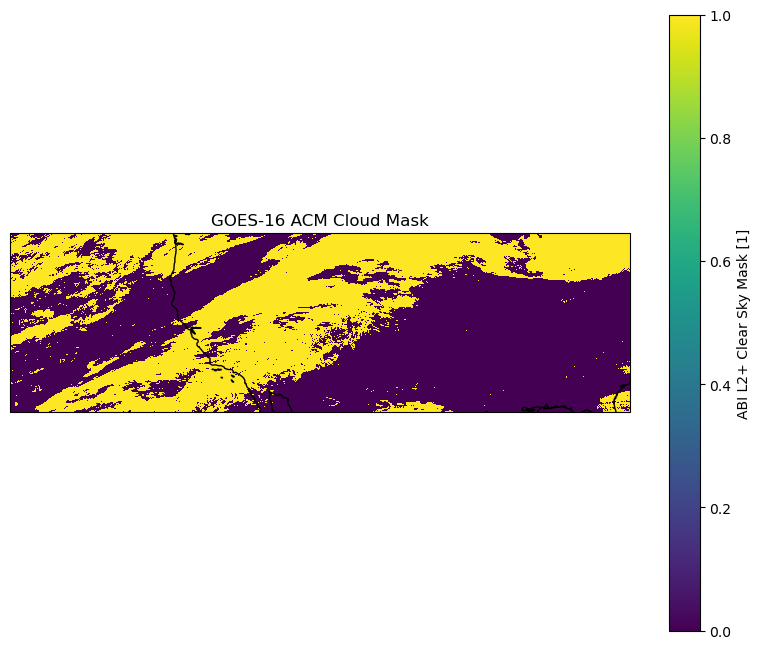

In [121]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# ds['BCM'].plot.imshow(x='longitude', y='latitude', ax=ax, add_colorbar=True, cmap='viridis', robust=True)
ds['BCM'].plot.imshow(x='longitude', y='latitude', ax=ax, add_colorbar=True, cmap='viridis', robust=True)


plt.title("GOES-16 ACM Cloud Mask")
plt.show()

In [107]:
ds_subset = xr.open_dataset(path + in_file + '_subset.nc', decode_cf=False)
ds = xr.open_dataset(path+in_file+'.nc')
proj_info = ds['goes_imager_projection']
x = ds['x'].values
y = ds['y'].values

# Build the GOES-R projection
sat_h = proj_info.perspective_point_height
sat_lon = proj_info.longitude_of_projection_origin
semi_major = proj_info.semi_major_axis
semi_minor = proj_info.semi_minor_axis

# Define projection
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon,
         a=semi_major, b=semi_minor)

X, Y = np.meshgrid(x * sat_h, y * sat_h)  # convert radians to projected meters
lon, lat = p(X, Y, inverse=True)
lon = np.where(np.isfinite(lon), lon, np.nan)  # Replace inf with NaN
lat = np.where(np.isfinite(lat), lat, np.nan)  # Replace inf with NaN


# ds = ds.assign_coords(
#     y=lat[:,0],  # Replace y with the first row of lat
#     x=lon[0, :]   # Replace x with the first column of lon
# )
# ds = ds.rename({"x": "longitude", "y": "latitude"})


# ds = ds.where((ds.longitude >= -140) & (ds.longitude <= -100), drop=True)
# ds = ds.where((ds.latitude >= 30) & (ds.latitude <= 50), drop=True)
ds


<xarray.Dataset> Size: 60MB
Dimensions:                                                     (y: 1500,
                                                                 x: 2500,
                                                                 number_of_time_bounds: 2,
                                                                 number_of_image_bounds: 2,
                                                                 RTM_BT_comparison_bands: 2,
                                                                 number_of_focal_planes_used: 2,
                                                                 number_of_LZA_bounds: 2,
                                                                 number_of_SZA_bounds: 2)
Coordinates:
  * y                                                           (y) float32 6kB ...
  * x                                                           (x) float32 10kB ...
    t                                                           datetime64[ns] 8B ...
    y_image                                                     float32 4B ...
    x_image                                                     float32 4B ...
    retrieval_local_zenith_angle                                float32 4B ...
    quantitative_local_zenith_angle                             float32 4B ...
    retrieval_solar_zenith_angle                                float32 4B ...
    RTM_BT_comparison_wavelengths                               (RTM_BT_comparison_bands) float32 8B ...
    RTM_BT_comparison_band_ids                                  (RTM_BT_comparison_bands) int8 2B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                RTM_BT_comparison_bands,
                                number_of_focal_planes_used,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/41)
    BCM                                                         (y, x) float32 15MB ...
    ACM                                                         (y, x) float32 15MB ...
    Cloud_Probabilities                                         (y, x) float32 15MB ...
    DQF                                                         (y, x) float32 15MB ...
    time_bounds                                                 (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                                      int32 4B ...
    ...                                                          ...
    quantitative_local_zenith_angle_bounds                      (number_of_LZA_bounds) float32 8B ...
    twilight_solar_zenith_angle                                 float32 4B ...
    retrieval_solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 8B ...
    twilight_solar_zenith_angle_bounds                          (number_of_SZA_bounds) float32 8B ...
    percent_uncorrectable_GRB_errors                            float32 4B ...
    percent_uncorrectable_L0_errors                             float32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2023-02-06T16:05:02.7Z
    time_coverage_start:       2023-02-06T16:01:17.1Z
    time_coverage_end:         2023-02-06T16:03:54.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        730a9a70-4624-4b0c-a0b8-1d3ba5a4bf58

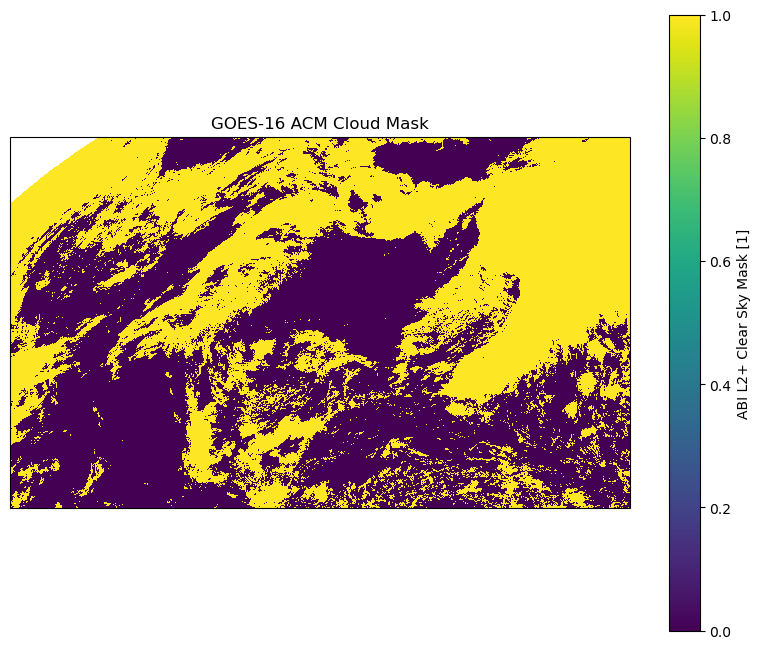

In [104]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# ds['BCM'].plot.imshow(x='longitude', y='latitude', ax=ax, add_colorbar=True, cmap='viridis', robust=True)
ds['BCM'].plot.imshow(x='x', y='y', ax=ax, add_colorbar=True, cmap='viridis', robust=True)


plt.title("GOES-16 ACM Cloud Mask")
plt.show()

In [32]:




# Bounds: [lon_min, lat_min, lon_max, lat_max]
bounds = [-109, 41, -104, 37]

# Extract dimensions of x and y
x_dim = ds_subset.sizes['x']  # Length of x dimension
y_dim = ds_subset.sizes['y']

# Generate longitude and latitude values
longitude = np.linspace(bounds[0], bounds[2], x_dim)  # From -125 to -100
latitude = np.linspace(bounds[1], bounds[3], y_dim)  # From 30 to 50

# Reassign x and y to lon and lat
ds_subset = ds_subset.assign_coords(x=("x", longitude), y=("y", latitude))
ds_subset = ds_subset.rename({"x": "longitude", "y": "latitude"})

ds_subset


<xarray.Dataset> Size: 620kB
Dimensions:                                                     (latitude: 160,
                                                                 longitude: 241,
                                                                 number_of_time_bounds: 2,
                                                                 number_of_image_bounds: 2,
                                                                 RTM_BT_comparison_bands: 2,
                                                                 number_of_focal_planes_used: 2,
                                                                 number_of_LZA_bounds: 2,
                                                                 number_of_SZA_bounds: 2)
Coordinates:
  * latitude                                                    (latitude) float64 1kB ...
  * longitude                                                   (longitude) float64 2kB ...
    t                                                           datetime64[ns] 8B ...
    y_image                                                     float32 4B ...
    x_image                                                     float32 4B ...
    retrieval_local_zenith_angle                                float32 4B ...
    quantitative_local_zenith_angle                             float32 4B ...
    retrieval_solar_zenith_angle                                float32 4B ...
    RTM_BT_comparison_wavelengths                               (RTM_BT_comparison_bands) float32 8B ...
    RTM_BT_comparison_band_ids                                  (RTM_BT_comparison_bands) int8 2B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                RTM_BT_comparison_bands,
                                number_of_focal_planes_used,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/41)
    BCM                                                         (latitude, longitude) float32 154kB ...
    ACM                                                         (latitude, longitude) float32 154kB ...
    Cloud_Probabilities                                         (latitude, longitude) float32 154kB ...
    DQF                                                         (latitude, longitude) float32 154kB ...
    time_bounds                                                 (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                                      int32 4B ...
    ...                                                          ...
    quantitative_local_zenith_angle_bounds                      (number_of_LZA_bounds) float32 8B ...
    twilight_solar_zenith_angle                                 float32 4B ...
    retrieval_solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 8B ...
    twilight_solar_zenith_angle_bounds                          (number_of_SZA_bounds) float32 8B ...
    percent_uncorrectable_GRB_errors                            float32 4B ...
    percent_uncorrectable_L0_errors                             float32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2023-02-06T16:05:02.7Z
    time_coverage_start:       2023-02-06T16:01:17.1Z
    time_coverage_end:         2023-02-06T16:03:54.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        730a9a70-4624-4b0c-a0b8-1d3ba5a4bf58

In [33]:
# Downscale rgb_ds to match the resolution of ds_sub
rgb_ds_resampled = rgb_ds.interp_like(ds_subset)

# Add ds_sub['BCM'] to the resampled rgb_ds
rgb_ds_resampled['goes_clouds'] = xr.where(ds_subset['BCM'] == 1, 0, 1)

rgb_ds_resampled 

<xarray.Dataset> Size: 2MB
Dimensions:                          (latitude: 160, longitude: 241)
Coordinates:
  * latitude                         (latitude) float64 1kB 41.0 40.97 ... 37.0
  * longitude                        (longitude) float64 2kB -109.0 ... -104.0
    t                                datetime64[ns] 8B 2023-02-06T16:02:30
    y_image                          float32 4B ...
    x_image                          float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
Data variables:
    green                            (latitude, longitude) float64 308kB 0.21...
    blue                             (latitude, longitude) float64 308kB 0.13...
    red                              (latitude, longitude) float64 308kB 0.36...
    clouds                           (latitude, longitude) float64 308kB 0.0 ...
    goes_clouds                      (latitude, longitude) int64 308kB 0 0 ... 1

Accuracy: 0.33
Precision: 0.31
Recall: 0.12
F1 Score: 0.17


Text(0.5, 1.0, 'Difference Map (clouds - BCM)')

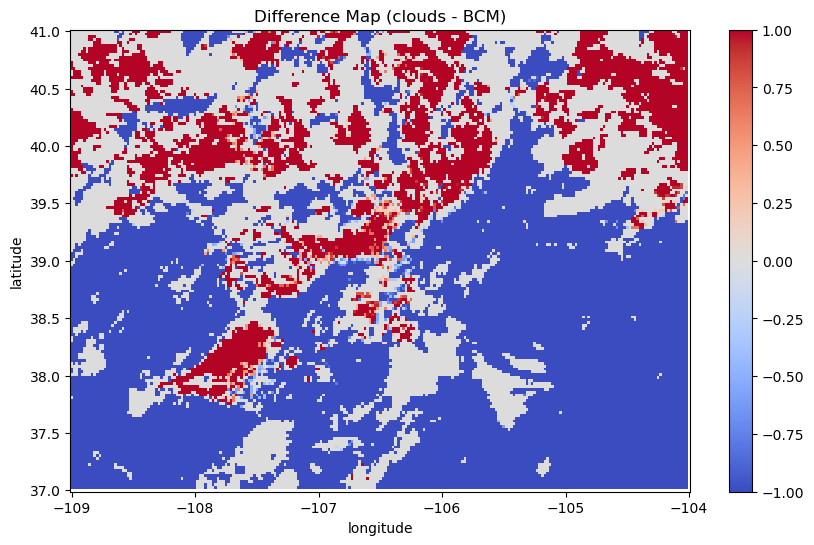

In [34]:
# 1. Compute the difference map
difference_map = rgb_ds_resampled.clouds - rgb_ds_resampled.goes_clouds

# 2. Calculate performance metrics
clouds = rgb_ds_resampled.clouds.values.flatten()
bcm = rgb_ds_resampled.goes_clouds.values.flatten()

# True Positives, False Positives, True Negatives, False Negatives
tp = np.sum((clouds == 1) & (bcm == 1))
fp = np.sum((clouds == 1) & (bcm == 0))
tn = np.sum((clouds == 0) & (bcm == 0))
fn = np.sum((clouds == 0) & (bcm == 1))

# Metrics
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# 3. Plot the difference map
plt.figure(figsize=(10, 6))
difference_map.plot(cmap='coolwarm', add_colorbar=True)
plt.title("Difference Map (clouds - BCM)")

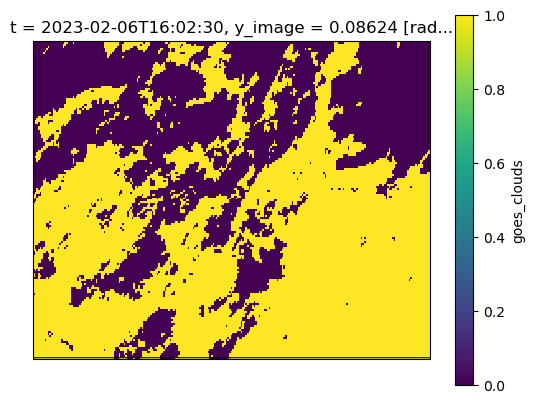

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
rgb_ds_resampled['goes_clouds'].plot.imshow(x='longitude', y='latitude', ax=ax)
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')

In [13]:
path = '/home/cdalden/data/noaa-goes16/ABI-L2-ACMC/'
file = '20230206_goes_mask_combined.nc'
mask_ds = xr.open_dataset(path + file)
latitude, longitude = calculate_degrees(ds)
mask_ds = mask_ds.assign_coords(y=("y", latitude[:,0]), x=("x", longitude[0,:]))
mask_ds = mask_ds.rename({'y':'latitude', 'x':'longitude'})
mask_ds = mask_ds.sortby(['latitude', 'longitude'])

mask_ds = mask_ds.dropna(dim='latitude', how='any')
mask_ds = mask_ds.sel(longitude=~np.isnan(mask_ds.longitude))
mask_ds = mask_ds.sel(
    latitude=slice(37, 41), 
    longitude=slice(-109, -104))

KeyError: 'x'

In [14]:
# Add ds_sub['BCM'] to the resampled rgb_ds
mask_ds['goes_clouds'] = xr.where(mask_ds['BCM'] == 1, 0, 1)

In [3]:
# Obtain a GOES ABI multichannel image
G = GOES(satellite=16, product="ABI", domain="C")
ds = G.nearesttime("2022-08-04 18:00")

latitude, longitude = calculate_degrees(ds)
ds = ds.assign_coords(y=("y", latitude[:,0]), x=("x", longitude[0,:]))
ds = ds.rename({'y':'latitude', 'x':'longitude'})
ds = ds.sortby(['latitude', 'longitude'])

ds = ds.dropna(dim='latitude', how='any')
ds = ds.sel(longitude=~np.isnan(ds.longitude))
ds = ds.sel(
    latitude=slice(32, 45), 
    longitude=slice(-120, -100))


ds

 👮🏻‍♂️ File already exists. Do not overwrite: /home/cdalden/data/noaa-goes16/ABI-L2-MCMIPC/2022/216/18/OR_ABI-L2-MCMIPC-M6_G16_s20222161801175_e20222161803553_c20222161804066.nc
📦 Finished downloading [1] files to [/home/cdalden/data/noaa-goes16/ABI-L2-MCMIPC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

<xarray.Dataset> Size: 24MB
Dimensions:                                 (latitude: 422, longitude: 441,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/41)
  * latitude                                (latitude) float64 3kB 32.0 ... 4...
  * longitude                               (longitude) float64 4kB -120.0 .....
    t                                       datetime64[ns] 8B 2022-08-04T18:0...
    y_image                                 float32 4B 0.08624
    x_image                                 float32 4B -0.03136
    band_wavelength_C01                     (band) float32 4B 0.47
    ...                                      ...
    band_id_C15                             (band) int8 1B 15
    band_id_C16                             (band) int8 1B 16
    dataset_name                            <U74 296B 'OR_ABI-L2-MCMIPC-M6_G1...
    date_created                            <U22 88B '2022-08-04T18:04:06.6Z'
    time_coverage_start                     <U22 88B '2022-08-04T18:01:17.5Z'
    time_coverage_end                       <U22 88B '2022-08-04T18:03:55.3Z'
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/125)
    CMI_C01                                 (latitude, longitude) float32 744kB ...
    DQF_C01                                 (latitude, longitude) float32 744kB ...
    CMI_C02                                 (latitude, longitude) float32 744kB ...
    DQF_C02                                 (latitude, longitude) float32 744kB ...
    CMI_C03                                 (latitude, longitude) float32 744kB ...
    DQF_C03                                 (latitude, longitude) float32 744kB ...
    ...                                      ...
    std_dev_brightness_temperature_C16      float32 4B 13.67
    percent_uncorrectable_GRB_errors        float32 4B 0.0
    percent_uncorrectable_L0_errors         float32 4B 0.0
    dynamic_algorithm_input_data_container  int32 4B -2147483647
    algorithm_product_version_container     int32 4B -2147483647
    filename                                <U112 448B 'noaa-goes16/ABI-L2-MC...
Attributes: (12/26)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    processing_level:          National Aeronautics and Space Administration ...
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        791b85a9-fd94-42b8-bf13-d53a14a4ec79
    path:                      ['noaa-goes16/ABI-L2-MCMIPC/2022/216/18/OR_ABI...

Text(0.01, 0.97, '18:02 UTC 04 August 2022')

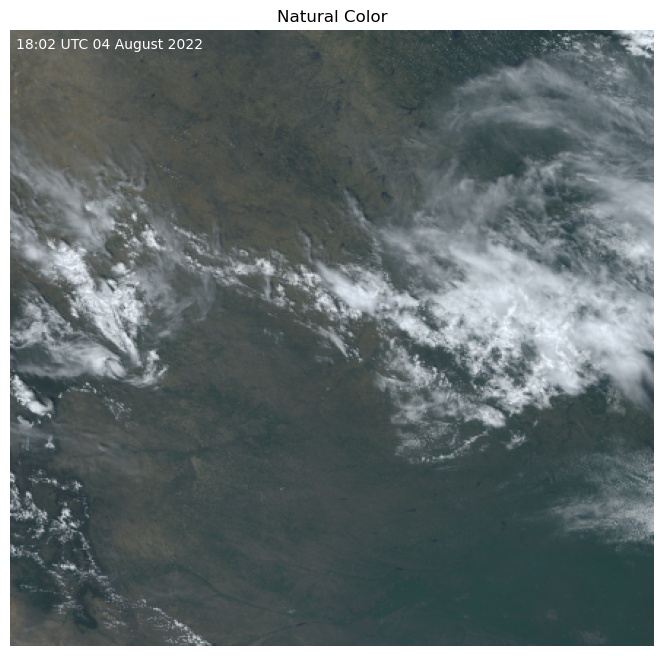

In [4]:

nc = ds.rgb.NaturalColor()


fig, ax = plt.subplots(1, 1, figsize=[15, 8])

text = ds.t.dt.strftime("%H:%M UTC %d %B %Y").item()

ax.axis("off")
ax.imshow(nc)
ax.set_title("Natural Color")
ax.text(0.01, 0.97, text, color="w", transform=ax.transAxes)



In [18]:
# Obtain a GOES ABI multichannel image
G = GOES(satellite=16, product="ABI-L2-ACMC", domain="C")
ds = G.nearesttime("2022-08-04 18:00")

 👮🏻‍♂️ File already exists. Do not overwrite: /home/cdalden/data/noaa-goes16/ABI-L2-ACMC/2022/216/18/OR_ABI-L2-ACMC-M6_G16_s20222161801175_e20222161803548_c20222161805158.nc
📦 Finished downloading [1] files to [/home/cdalden/data/noaa-goes16/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

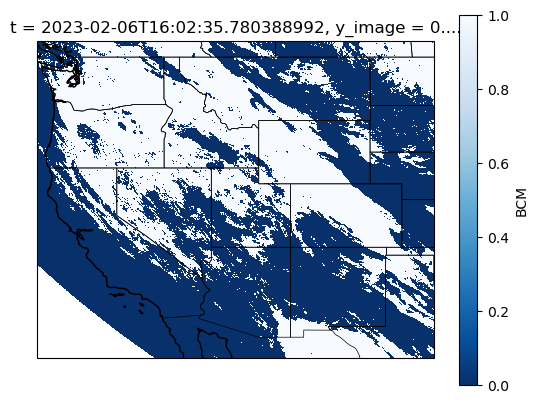

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})


ds_subset['BCM'].plot.imshow(x='x', y='y', ax=ax, cmap='Blues_r')
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')